# Implementation Of The Finite Difference Scheme For The Diffusion Equation

## Consumption reaction rate

In this section we implement a numeric solution to the diffusion equation. We have already found the analytic solution, which is 
$$
    \newcommand{\qty}[1]
    {
        \left({#1}\right)
    }
    \newcommand{\qtys}[1]
    {
        \left[{#1}\right]
    }
$$     

\begin{align}
	C_-(\xi,\tau) = C_b\qty{\qty{\frac{1 +\frac{k_f\delta}{D}\xi }{1+\frac{k_f\delta}{D}} } - 2\sum_\lambda  \frac{e^{-\lambda^2 \tau}\cos(\lambda\xi)}{\lambda \sin(\lambda) \qty{1+cot^2(\lambda)\qty{1+\frac{D}{k_f \delta}}}}  \qty{1 + \frac{k_f\delta}{D}\frac{\tan(\lambda\xi)}{\lambda}}}
\end{align}

Where $\lambda$ must be computed numerically for each period of $\tan(\lambda)$ from the equation

\begin{align}
	\tan(\lambda) = -\frac{D\lambda}{k_f\delta}
\end{align}

Also, the steady state solution is

\begin{align}
    C_{SS}(\xi) = C_b\qty{\frac{1 +\frac{k_f\delta}{D}\xi }{1+\frac{k_f\delta}{D}} }
\end{align}


### Numerical solution of the $\lambda$ eigen values.

Consider,

$$ \lambda = (2m + 1)\frac{\pi}{2} z$$

Then the equation to solve is

\begin{align}
	\tan\qty{ (2m + 1)\frac{\pi}{2}} = -\frac{D (2m + 1)\pi}{2k_f\delta}
\end{align}



In [1]:
import matplotlib.pyplot as plt
import numpy as np

M = 500
xi = np.linspace(0,1, M)

mw = 4
fs = 24

def remove_points(A):
    A = np.delete(A, [1, 2, 3])
    for i in range(0,int(len(A)/4)):
        index = i+4
        A = np.delete(A, [index-2, index-1, index])
    return A

In [2]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

# Define grid parameters

N = 1000000
M = 250
xi = np.linspace(0,1, M)
tau = np.linspace(0,1, N) #shape is N+1

dtau = 1/(N)  # N Partitions
dxi = 1/(M) # N Partitions 
a = dtau / dxi ** 2 
print(a)
params = { 'bulkConcentration': 100, 'diffusionCoefficient': 1.07e-9, 'laminarFlowRegion': 1e-10, 'reactionRate': 1e2 }
Cb = params['bulkConcentration']
D = params['diffusionCoefficient']
d = params['laminarFlowRegion']
kf = params['reactionRate']

# Define the coefficient matrix
g = 1 / ( 1 + kf * d / D * dxi )
di = ( 1 - 2 * a ) * np.ones(M-2)
di[0] = ( 1 - 2 * a + a * g )
A = diags(np.array([ a * np.ones(M-3), di, a * np.ones(M-3)]), [-1, 0, 1], shape=(M-2, M-2)).toarray()


def C(t):
    # Set up initial conditions for \rho
    C_ss = Cb * (1 + kf * d / D * xi )/( 1 + kf * d / D )
    
    rho = np.zeros([N, M])
    rho = np.zeros([N, M])
    
    rho[0, :] = -C_ss/Cb
    rho[:, -1] = 0    
    
    #Starting iteration
    for n in range(0, N-1):
        rho[n+1, 1:M-1] = np.matmul(A, rho[n, 1:M-1])
        rho[n+1, 0] = g * rho[n+1, 1]
        
    n = int(t/dtau)
    
    return C_ss + Cb * rho[n, :]

#Cm is the imported analytical solution
def remove_points(A):
    A = np.delete(A, [1, 2, 3])
    for i in range(0,int(len(A)/4)):
        index = i+4
        A = np.delete(A, [index-2, index-1, index])
    return A

0.0625


## Numeric solution for consumtion reaction rate

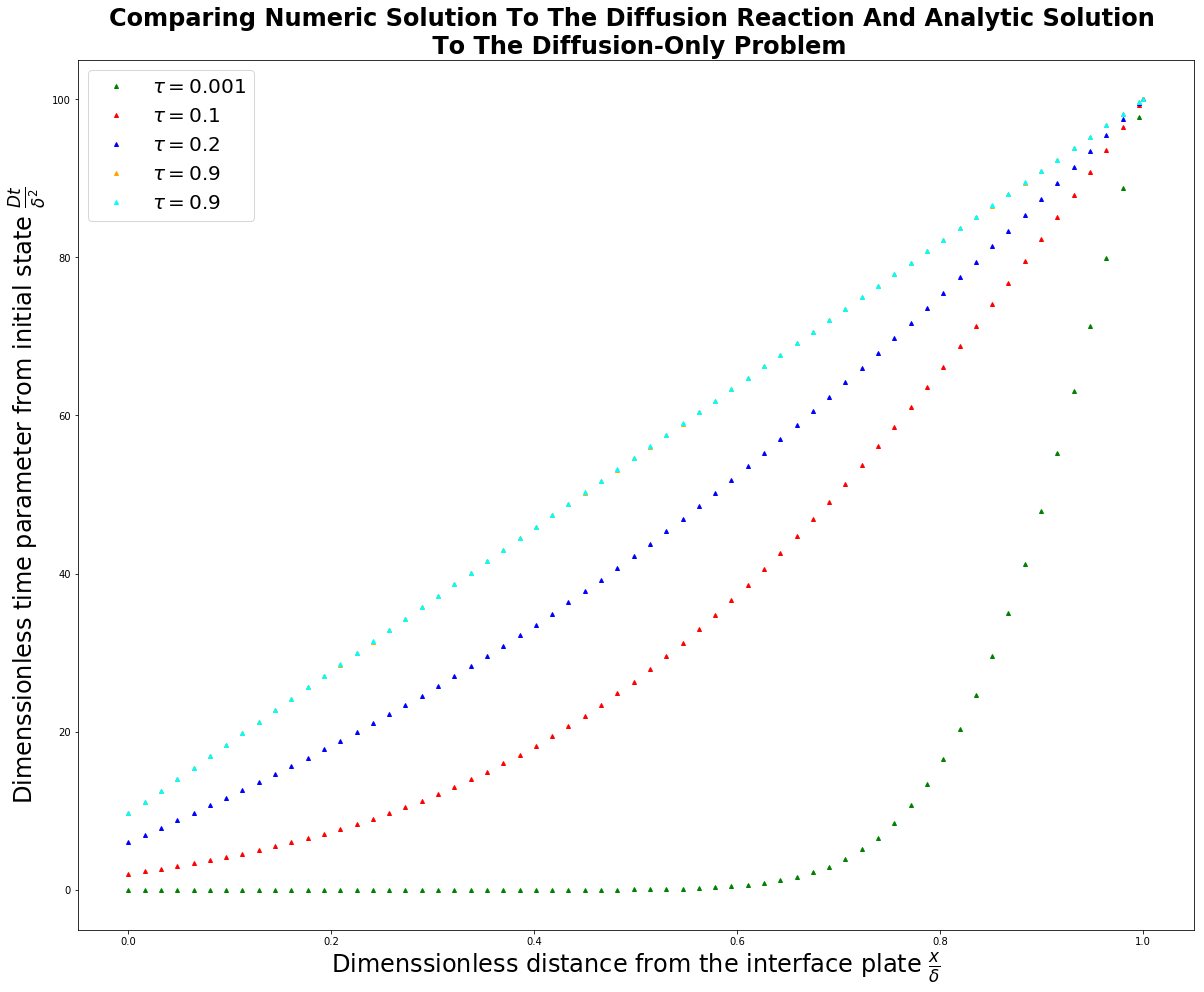

In [3]:
import matplotlib.pyplot as plt
import analyticDiffusionLangmuirBC

Cm = analyticDiffusionLangmuirBC.C_an
mw = 4
fs = 24
xi2 = remove_points(xi) # this is done to avoid cluttering of numeric points over the analytic solution
fig = plt.figure(figsize=(20,16))
plt.title('Comparing Numeric Solution To The Diffusion Reaction And Analytic Solution \n To The Diffusion-Only Problem', fontsize=fs, fontweight='bold')
plt.plot(xi2, remove_points(C(0.01)), 'g^', markersize=mw, label=r'$\tau=0.001$')
plt.plot(xi2, remove_points(C(0.1)), 'r^', markersize=mw, label=r'$\tau = 0.1$')
plt.plot(xi2, remove_points(C(0.2)), 'b^', markersize=mw, label = r'$\tau=0.2$')
plt.plot(xi2, remove_points(C(0.9)), '^', markersize=mw, color="orange", label = r'$\tau=0.9$')
plt.plot(xi2, remove_points(C(0.99)), '^', markersize=mw, color="aqua", label = r'$\tau=0.9$')
plt.xlabel(r'Dimenssionless distance from the interface plate $\frac{x}{\delta}$', fontsize=fs)
plt.ylabel(r'Dimenssionless time parameter from initial state $\frac{Dt}{\delta^2}$', fontsize=fs)
#plt.text(0.9, 40, r'Reaction Rate', fontsize = 14, color = 'black')
#plt.text(0.9, 37, r'$r = - 1.5 \times 10 \frac{A}{m^2}$', fontsize = 14, color = 'black')
plt.legend(fontsize = fs-4)
plt.savefig('../../../img/concentration-diffusion-reaction-comparison.eps', format='eps', dpi=1000, fontsize=16, fontweight='bold')
plt.show()

## Comparison with analytic solution

In [4]:
import matplotlib.pyplot as plt
from bisection import findRoot

def findLambdas(params, N = 50):

    def f(z, m): 
        # a = (2 * m + 1) * np.pi / 2 * z
        return np.tan((2 * m + 1) * np.pi / 2 * z) + D / (kf * d) * (2 * m + 1) * np.pi / 2 * z
        #return np.tan(z) + D / (kf * d) * z

    # note that tau = D t / xb ** 2, where t is the time
    Cb = params['bulkConcentration']
    D = params['diffusionCoefficient']
    d = params['laminarFlowRegion']
    kf = params['reactionRate']
    cond = True
    
    print("Starting iteration")
    er = 0.5e-15
    

    #print("Finding " + str(2*N) + " roots...")
    print("Finding " + str(N) + " roots...")
    LR = []
    LL = []
    #Forward
    for i in range(0,N):
        #Search for root of f (find lambda --a in this code)
        #a = (2 * i + 1) * np.pi / 2 + er
        #b = (2 * i + 3) * np.pi /2 - er
        a = 1 + er
        b = 3 - er
        z = findRoot(f, i, a, b)
        if (z == None):
            print("Found NoneType Lambda at N = "+str(i))
            break
        lam = (2 * i + 1 ) * np.pi / 2 * z
        LR.append(lam)
    LR = np.array(LR) 
    #backwards   
    #for i in range(0,N):
        #Search for root of f (find lambda --a in this code)
    #    a = -1 - er
    #    b = -3 + er
    #    z = findRoot(f, i, a, b)
    #    if (z == None):
    #        print("Found NoneType Lambda at N = "+str(i))
    #        break
    #    lam = (2 * i + 1 ) * np.pi / 2 * z
    #    LL.append(lam) 
    LL = -1 * np.array(LR)
    print("Done Computing lambdas")
    return LL, LR 

#NUM is the number 1/2 of LAMBDAS TO FIND
NUM = 10000
LL, LR = findLambdas(params, NUM)
#LAMBDAS_ = np.concatenate([LL, LR]) 
LAMBDAS_ = LR


Starting iteration
Finding 10000 roots...
Done Computing lambdas


Computation finished
Computation finished
Computation finished
Computation finished
Computation finished
Computation finished


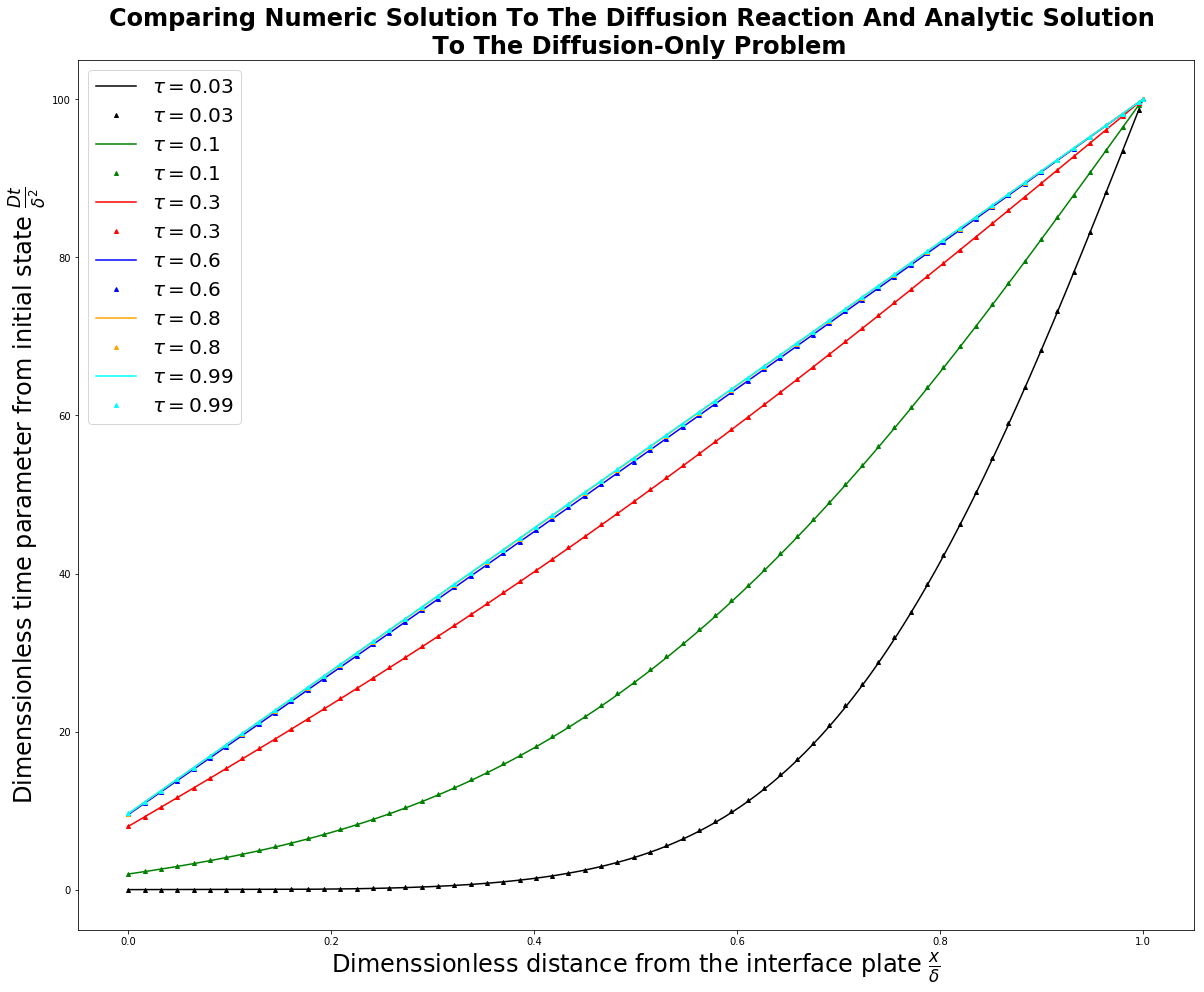

In [5]:
import analyticDiffusionLangmuirBC

Cm = analyticDiffusionLangmuirBC.C_an
mw = 4
fs = 24

t1 = 0.03
t2 = 0.1
t3 = 0.3
t4 = 0.6
t5 = 0.8
t6 = 0.99
xi2 = remove_points(xi) # this is done to avoid cluttering of numeric points over the analytic solution
fig = plt.figure(figsize=(20,16))
plt.title('Comparing Numeric Solution To The Diffusion Reaction And Analytic Solution \n To The Diffusion-Only Problem', fontsize=fs, fontweight='bold')
plt.plot(xi, Cm(xi, t1, LAMBDAS_ , params), '-', color="black", label=r'$\tau='+ str(t1) + '$')
plt.plot(xi2, remove_points(C(t1)), '^', color="black", markersize=mw, label=r'$\tau='+ str(t1) + '$')
plt.plot(xi, Cm(xi, t2, LAMBDAS_ , params), 'g-', label=r'$\tau='+ str(t2) + '$')
plt.plot(xi2, remove_points(C(t2)), 'g^', markersize=mw, label=r'$\tau='+ str(t2) + '$')
plt.plot(xi, Cm(xi, t3, LAMBDAS_, params), 'r-', label=r'$\tau='+ str(t3) + '$')
plt.plot(xi2, remove_points(C(t3)), 'r^', markersize=mw, label=r'$\tau='+ str(t3) + '$')
plt.plot(xi, Cm(xi, t4, LAMBDAS_, params), 'b-', label = r'$\tau='+ str(t4) + '$')
plt.plot(xi2, remove_points(C(t4)), 'b^', markersize=mw, label = r'$\tau='+ str(t4) + '$')
plt.plot(xi, Cm(xi, t5, LAMBDAS_, params), '-', color="orange", label = r'$\tau='+ str(t5) + '$')
plt.plot(xi2, remove_points(C(t5)), '^', markersize=mw, color="orange", label = r'$\tau='+ str(t5) + '$')
plt.plot(xi, Cm(xi, t6, LAMBDAS_, params), '-', color="aqua", label = r'$\tau='+ str(t6) + '$')
plt.plot(xi2, remove_points(C(t6)), '^', markersize=mw, color="aqua", label = r'$\tau='+ str(t6) + '$')
plt.xlabel(r'Dimenssionless distance from the interface plate $\frac{x}{\delta}$', fontsize=fs)
plt.ylabel(r'Dimenssionless time parameter from initial state $\frac{Dt}{\delta^2}$', fontsize=fs)
plt.legend(fontsize = fs-4)
plt.savefig('../../../img/concentration-diffusion-reaction-robin-comparison.eps', format='eps', dpi=1000, fontsize=16, fontweight='bold')
plt.show()